# Tutorial: `bayes.BayesClassifier` (minimal & scikit-learn friendly)

Este notebook muestra cómo instalar y usar **BayesClassifier** con:
- **X** = `pandas.DataFrame` binario (0/1)  
- **y** = vector binario (0/1) ya preparado por el usuario  
- Métricas estilo scikit-learn: **ROC / AUC con CV**

> Nota importante: en Colab a veces existe un paquete externo llamado `bayes` que puede chocar con el tuyo.
> Por eso forzamos desinstalación + reinstalación sin cache.


## 1) Instalación desde GitHub (Colab)

In [1]:
# Instala tu repo (sin cache, forzando reinstalación)
!pip install  git+https://github.com/CRISTIANJULIOCESAR/naive_bayes.git

  Cloning https://github.com/CRISTIANJULIOCESAR/naive_bayes.git to /tmp/pip-req-build-p0p40kge
  Running command git clone --filter=blob:none --quiet https://github.com/CRISTIANJULIOCESAR/naive_bayes.git /tmp/pip-req-build-p0p40kge
  Resolved https://github.com/CRISTIANJULIOCESAR/naive_bayes.git to commit c47da9ab7e748676f0af0c4b0eb1f6c12d481f95
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bayes-minimal: filename=bayes_minimal-0.1.1-py3-none-any.whl size=4700 sha256=c5597c3bc492afa361565dff50dd67465055256066f713ee98dc46f60dae5936
  Stored in directory: /tmp/pip-ephem-wheel-cache-3gjcqybj/wheels/2b/09/c1/e43cfd9834b96d401a952dcb876e7e4c2864e6a2c6025ff352
Successfully built bayes-minimal


### Verifica que estás importando TU `bayes`

In [2]:
import bayes
print("✅ bayes importado desde:", bayes.__file__)
print("✅ clase:", bayes.BayesClassifier)


✅ bayes importado desde: /usr/local/lib/python3.12/dist-packages/bayes/__init__.py
✅ clase: <class 'bayes.model.BayesClassifier'>


## 2) Prueba rápida con datos sintéticos SIN `|`
Aquí X tiene columnas simples (`var_0`, `var_1`, …).  
**Esperado**: la tabla `feature_table_` debe tener columna `feature` y **NO** debe tener `Subcategoría/Valor_Variable`.


In [3]:
import numpy as np
import pandas as pd

np.random.seed(42)

n = 500   # instancias
p = 120   # variables

X = pd.DataFrame(
    np.random.binomial(1, 0.15, size=(n, p)),
    columns=[f"var_{i}" for i in range(p)]
)

# Señal real (para que el modelo aprenda algo):
# var_0 y var_1 aumentan prob, var_2 la reduce
logit = 2.4*X["var_0"].values + 1.6*X["var_1"].values - 1.2*X["var_2"].values - 0.7
prob = 1 / (1 + np.exp(-logit))
y = (np.random.rand(n) < prob).astype(int)

print("X:", X.shape, "| positivos y=1:", int(y.sum()), "/", len(y))
print("¿Hay '|' en columnas?:", any("|" in c for c in X.columns))


X: (500, 120) | positivos y=1: 215 / 500
¿Hay '|' en columnas?: False


In [9]:
clf = bayes.BayesClassifier(alpha=0.4, min_cases=10, use_prior=True)
clf.fit(X, y)

# Tabla interpretabilidad (debe mostrar columna "feature")
clf.feature_table_.head(15)


,feature,N(CX),N(X),P(C|X),P(C),Epsilon,Score
0,var_0,68,80,0.850000,0.43,7.587918,1.989071
1,var_1,49,70,0.700000,0.43,4.562902,1.117954
2,var_52,43,73,0.589041,0.43,2.744727,0.637412
3,var_116,40,71,0.563380,0.43,2.270122,0.533417
4,var_36,39,71,0.549296,0.43,2.030405,0.477002
5,var_76,43,80,0.537500,0.43,1.942146,0.430184
6,var_81,38,71,0.535211,0.43,1.790687,0.420896
7,var_23,41,77,0.532468,0.43,1.816185,0.410107
8,var_114,37,71,0.521127,0.43,1.550970,0.365009
9,var_44,44,85,0.517647,0.43,1.632207,0.351354


### Leer una fila (intuición)
- **N(X)** = cuántas instancias tienen esa feature en 1  
- **N(CX)** = cuántas de esas instancias son positivas (y=1)  
- **P(C|X)** = N(CX)/N(X)  
- **P(C)** = prevalencia global de positivos  
- **Score** = peso (log-odds) que se suma cuando esa feature está activa  
- **Epsilon** = fuerza de señal (comparando P(C|X) vs P(C), ajustado por N(X))


## 3) Prueba con datos sintéticos CON `|` (agrupación automática)
Aquí simulamos columnas tipo `grupo|categoria` (ej: `azucar|3_Alto`).

**Esperado**: la tabla debe verse estilo Proyecto 42:
- `Subcategoría`
- `Valor_Variable`
y **NO** debe mostrar `feature` redundante ni `group`.


In [5]:
np.random.seed(42)
n = 500

groups = {
    "azucar":   ["0_No", "1_Bajo", "2_Medio", "3_Alto"],
    "refresco": ["0_No", "1_Bajo", "2_Medio", "3_Alto"],
    "fruta":    ["0_No", "1_Bajo", "2_Medio", "3_Alto"],
    "verdura":  ["0_No", "1_Bajo", "2_Medio", "3_Alto"],
    "ejercicio":["0_No", "1_Si"],
}

cols = [f"{g}|{c}" for g, cats in groups.items() for c in cats]
X2 = pd.DataFrame(0, index=range(n), columns=cols, dtype=int)

# One-hot por grupo: exactamente 1 categoría activa por fila
for g, cats in groups.items():
    chosen = np.random.choice(cats, size=n, replace=True)
    for i, cat in enumerate(chosen):
        X2.loc[i, f"{g}|{cat}"] = 1

# Señal real con categorías específicas
logit = (
    2.3 * X2["azucar|3_Alto"].values +
    1.8 * X2["refresco|3_Alto"].values -
    1.4 * X2["verdura|3_Alto"].values -
    1.0 * X2["ejercicio|1_Si"].values -
    0.4
)
prob2 = 1 / (1 + np.exp(-logit))
y2 = (np.random.rand(n) < prob2).astype(int)

print("X2:", X2.shape, "| positivos y2=1:", int(y2.sum()), "/", len(y2))
print("¿Hay '|' en columnas?:", any("|" in c for c in X2.columns))


X2: (500, 18) | positivos y2=1: 246 / 500
¿Hay '|' en columnas?: True


In [6]:
clf2 = bayes.BayesClassifier(alpha=1.0, min_cases=10, use_prior=True, sep="|")
clf2.fit(X2, y2)

clf2.feature_table_.head(20)


,Subcategoría,Valor_Variable,N(CX),N(X),P(C|X),P(C),Epsilon,Score
0,azucar,3_Alto,121,148,0.817568,0.492,7.922415,1.503315
1,refresco,3_Alto,96,132,0.727273,0.492,5.406848,0.995292
2,verdura,2_Medio,77,132,0.583333,0.492,2.098949,0.362856
3,verdura,0_No,70,131,0.534351,0.492,0.969586,0.167044
4,ejercicio,0_No,138,260,0.530769,0.492,1.250430,0.154038
5,fruta,0_No,72,136,0.529412,0.492,0.872697,0.147571
6,fruta,3_Alto,52,101,0.514851,0.492,0.459368,0.089768
7,verdura,1_Bajo,65,127,0.511811,0.492,0.446575,0.078019
8,fruta,2_Medio,62,127,0.488189,0.492,-0.085907,-0.015021
9,refresco,2_Medio,50,110,0.454545,0.492,-0.785754,-0.147550


### Top riesgo / Top protector

In [7]:
top_riesgo = clf2.feature_table_.sort_values("Score", ascending=False).head(10)
top_protector = clf2.feature_table_.sort_values("Score", ascending=True).head(10)

display(top_riesgo)
display(top_protector)


,Subcategoría,Valor_Variable,N(CX),N(X),P(C|X),P(C),Epsilon,Score
0,azucar,3_Alto,121,148,0.817568,0.492,7.922415,1.503315
1,refresco,3_Alto,96,132,0.727273,0.492,5.406848,0.995292
2,verdura,2_Medio,77,132,0.583333,0.492,2.098949,0.362856
3,verdura,0_No,70,131,0.534351,0.492,0.969586,0.167044
4,ejercicio,0_No,138,260,0.530769,0.492,1.250430,0.154038
5,fruta,0_No,72,136,0.529412,0.492,0.872697,0.147571
6,fruta,3_Alto,52,101,0.514851,0.492,0.459368,0.089768
7,verdura,1_Bajo,65,127,0.511811,0.492,0.446575,0.078019
8,fruta,2_Medio,62,127,0.488189,0.492,-0.085907,-0.015021
9,refresco,2_Medio,50,110,0.454545,0.492,-0.785754,-0.147550


,Subcategoría,Valor_Variable,N(CX),N(X),P(C|X),P(C),Epsilon,Score
17,azucar,1_Bajo,33,108,0.305556,0.492,-3.875671,-0.772874
16,verdura,3_Alto,34,110,0.309091,0.492,-3.837225,-0.756959
15,refresco,1_Bajo,39,122,0.319672,0.492,-3.807334,-0.710439
14,azucar,2_Medio,43,122,0.352459,0.492,-3.082956,-0.566338
13,azucar,0_No,49,122,0.401639,0.492,-1.996388,-0.360543
12,fruta,1_Bajo,60,136,0.441176,0.492,-1.185550,-0.201433
11,refresco,0_No,61,136,0.448529,0.492,-1.014029,-0.172100
10,ejercicio,1_Si,108,240,0.450000,0.492,-1.301489,-0.167253
9,refresco,2_Medio,50,110,0.454545,0.492,-0.785754,-0.147550
8,fruta,2_Medio,62,127,0.488189,0.492,-0.085907,-0.015021


## 4) ROC / AUC con Validación Cruzada (CV=3) como scikit-learn
Con `cross_val_predict(method="predict_proba")` puedes obtener probabilidades out-of-fold y calcular AUC.


✅ AUC (CV=3): 0.8117


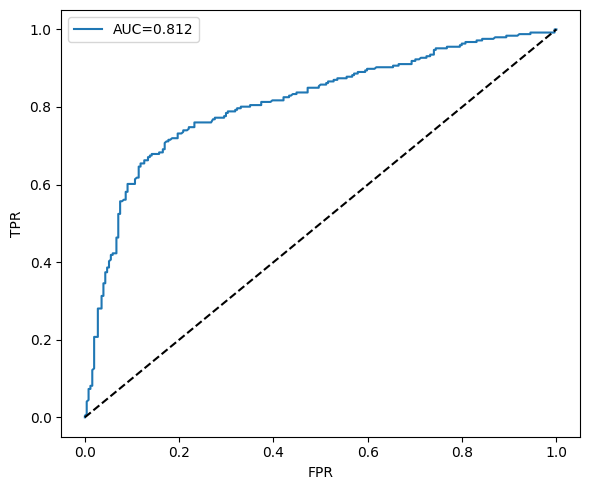

In [10]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y2_proba = cross_val_predict(
    bayes.BayesClassifier(alpha=1.0, min_cases=10, use_prior=True),
    X2, y2,
    cv=cv,
    method="predict_proba"
)[:, 1]

auc_val = roc_auc_score(y2, y2_proba)
fpr, tpr, _ = roc_curve(y2, y2_proba)

print("✅ AUC (CV=3):", round(auc_val, 4))

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC={auc_val:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.tight_layout()
plt.show()


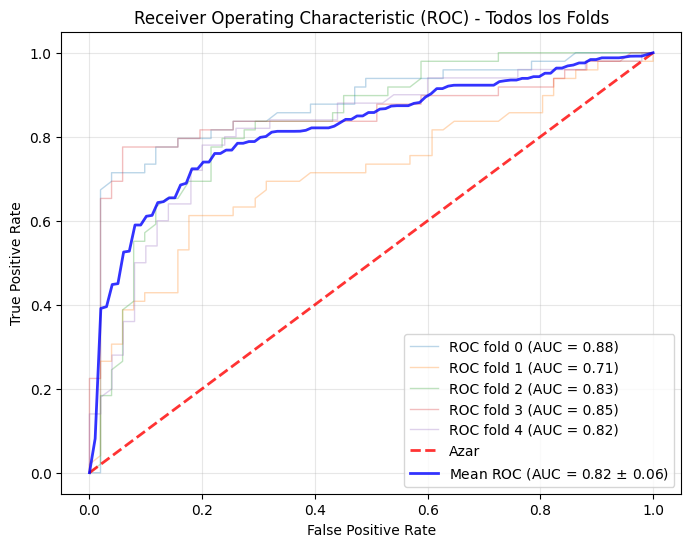

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
classifier = bayes.BayesClassifier(alpha=1.0, min_cases=10, use_prior=True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))

for i, (train, test) in enumerate(cv.split(X2, y2)):
    # CORRECCIÓN: X2 es DataFrame (usa .iloc), y2 es Numpy (usa corchetes directos)
    classifier.fit(X2.iloc[train], y2[train])

    # Predecir (X2 necesita .iloc)
    y_proba = classifier.predict_proba(X2.iloc[test])[:, 1]

    # Calcular ROC (y2 usa corchetes directos)
    fpr, tpr, thresholds = roc_curve(y2[test], y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label=f'ROC fold {i} (AUC = {roc_auc:.2f})')

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Azar', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Todos los Folds')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## 5) Uso con tus datos reales
Checklist rápida antes de `fit()`:

1. `X` debe ser DataFrame con **0/1**
2. `y` debe ser vector **0/1** (ya preparado)
3. Asegúrate de que `X` y `y` están alineados (mismas filas / mismo orden)

Ejemplo:
```python
clf = bayes.BayesClassifier(alpha=1.0, min_cases=10, use_prior=True)
clf.fit(X, y)
proba = clf.predict_proba(X)[:, 1]
tabla = clf.feature_table_
pesos = clf.weights_
```
